<a href="https://colab.research.google.com/github/nejdet/MachineLearning/blob/master/image_denoising_w_CNN/image_denoising_w_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMAGE DENOISING WITH CONVOLUTIONAL NEURAL NETWORKS**
Given notebook file will download 6 images from github repository. These images will be used to make list of 256x256 grayscale patches. 500 patches will be randomly selected from each images. Gaussian noise will be added to each patch.

CNN network will try to clean noise frome these patches. Noisy images will be our training set, and original images will be our target set.

#Libraries and Constants

In [0]:
from PIL import Image
import os, sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
%matplotlib inline

In [0]:
# Model configuration
img_width, img_height = 256, 256
batch_size = 100
no_epochs = 10
verbosity = 1
number_of_visualizations = 2
patch_per_image = 500

#Import Images from Github

In [0]:
import urllib.request
github_path = 'https://raw.githubusercontent.com/nejdet/MachineLearning/master/image_denoising_w_CNN/image/'
image_list = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']

images_dir = 'images'

if os.path.exists(images_dir) == False:
    os.mkdir(images_dir)

for fname in image_list:
    urllib.request.urlretrieve(github_path + fname, images_dir + '/' + fname)

# Creating Patches

In [0]:
path = "/content/images/"
dirs = os.listdir(path)
patches = []

for item in dirs:
    if os.path.isfile(path+item):
        img = Image.open(path+item)
        img = img.convert('L')
        img = np.asarray(img)
        img = img/255.0
        patches.extend(image.extract_patches_2d(img, (img_height, img_width), 
                                                    max_patches=patch_per_image, 
                                                    random_state=42))

# Adding Gaussian Noise

In [0]:
noisy_patches = []
row,col= patches[0].shape
mean = 0.0
var = 0.1

for patch in patches:
    noisy_image = random_noise(patch, mode='gaussian', clip=True, 
                           mean=mean, var=var)
    noisy_patches.append(noisy_image)

# Splitting the dataset and reshaping inputs for Convolutinal Network

In [0]:
input_train, input_test, target_train, target_test = train_test_split(noisy_patches, patches, test_size=0.33, random_state=42)

input_train = np.asarray(input_train)
input_test = np.asarray(input_test)
target_train = np.asarray(target_train)
target_test = np.asarray(target_test)

In [0]:
# Reshape data based on channels first / channels last strategy.
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    target_train = target_train.reshape(target_train.shape[0], 1, img_width, img_height)
    target_test = target_test.reshape(target_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    target_train = target_train.reshape(target_train.shape[0], img_width, img_height, 1)
    target_test = target_test.reshape(target_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)


#Create and Compile the Model

In [50]:
# Create the model
model = Sequential()

#Encoder
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
                 input_shape=input_shape))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

#Decoder
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.summary()


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)     

# Fit the Model to Dataset

In [51]:
history = model.fit(input_train, target_train,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_data=(input_test, target_test))


Epoch 1/10
21/21 [==============================] - 6s 307ms/step - loss: 0.5794 - val_loss: 0.5078
Epoch 2/10
21/21 [==============================] - 6s 303ms/step - loss: 0.5031 - val_loss: 0.5060
Epoch 3/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4984 - val_loss: 0.4968
Epoch 4/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4889 - val_loss: 0.4951
Epoch 5/10
21/21 [==============================] - 6s 304ms/step - loss: 0.4948 - val_loss: 0.4938
Epoch 6/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4894 - val_loss: 0.4939
Epoch 7/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4899 - val_loss: 0.4930
Epoch 8/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4897 - val_loss: 0.4931
Epoch 9/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4891 - val_loss: 0.4928
Epoch 10/10
21/21 [==============================] - 6s 303ms/step - loss: 0.4896 - val_loss: 0.4925

#Plot the Loss

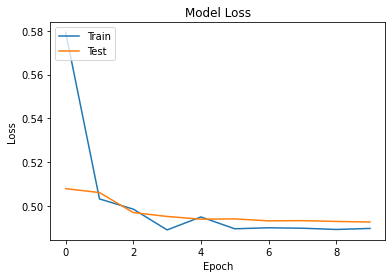

In [52]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Output - Input comparison

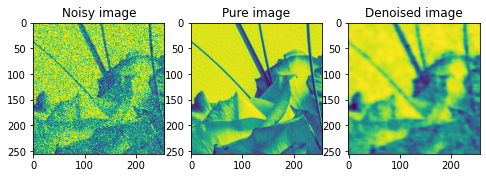

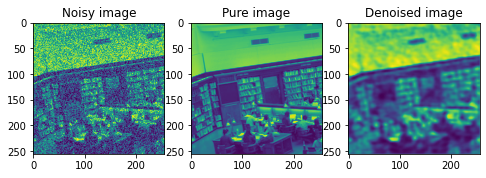

In [53]:
# Generate denoised images
samples = input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = model.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = input_test[i][:, :, 0]
  pure_image  = target_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  plt.show()
